<img src="http://www.exalumnos.usm.cl/wp-content/uploads/2015/06/Isotipo-Negro.gif" title="Title text" width="20%" height="20%" />


<hr style="height:2px;border:none"/>
<h1 align='center'> INF-477 Redes Neuronales Artificiales I-2018 </h1>

<H3 align='center'> Tarea 1 - Redes Neuronales y *Deep Learning* </H3>
<H3 align='center'>  Jorge Portilla / John Rodriguez </H3>

<hr style="height:2px;border:none"/>

**a) Construya un dataframe con los datos a analizar y descríbalo brevemete. Además, realice la división de éste en los conjuntos de entrenamiento, validación y testeo correspondientes. Comente por qué se deben eliminar ciertas columnas**

Las columnas 'Unnamed: 0' y 'pubchem_id' se eliminan por no tener datos relevante para los conjuntos de entrenamiento, validación y testeo. 'Unnamed: 0' es la columna que enumera las filas, por lo que no es necesaria debido a que el dataframe ya tiene una enumeración. 'pubchem_id' es una identificación del test, por lo que tampoco es relevante para las mediciones.


In [ ]:
import pandas as pd
datos= pd.read_csv("EnergyMolecule/roboBohr.csv")
datos.shape
datos.info()
print(datos.describe())
...
datos.drop(columns=['Unnamed: 0','pubchem_id'],axis=1,inplace=True) # con la propiedad drop elimina columnas
total=len(datos)
df_train=datos[:int(0.6*total)]                       #60% de los datos
df_val=datos[int(0.6*total):int(0.85*total)]          #25% de los datos
df_test=datos[int(0.85*total)::]                      #15% restante
print ("Imprimir dataset")
print (df_test)
print (total)

**a.1) Una buena práctica es la de normalizar los datos antes de trabajar con el modelo. Explique por qué se aconseja dicho preprocesamiento**

Para un mejor funcionamiento de los algoritmos de Machine learning, hay que normalizar las variables de entrada del algoritmo, Normalizar, hace referencia a extender o comprimir los valores de una variable para estar en un rango definido. Es decir, realiza una ponderación de las caracterisiticas de una mejor manera y ademas se reduce el facor de escala. Sin embargo, realizar una mala eleccion del metodo de normalización puede alterar los resultados del analisis de datos. En este caso, se realiza una estandarización de los datos, debido a que si usamos normalización los outlayers podrían causar un desbalance de los datos en el intervalo, haciendo que muchos de ellos se agrupen cerca del 0.0 y que el outlayer quede como -1 o 1.


In [ ]:
#Pre-processing#
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(df_train)
X_train_scaled = pd.DataFrame(scaler.transform(df_train),columns=df_train.columns)
X_val_scaled =  pd.DataFrame(scaler.transform(df_val),columns=df_val.columns)
X_test_scaled =  pd.DataFrame(scaler.transform(df_test),columns=df_test.columns)
...
print(X_train_scaled)
y_train = df_train.pop('Eat').values.reshape(-1,1)
y_val = df_val.pop('Eat').values.reshape(-1,1)
print(y_train)
...
X_train_scaled.drop(columns=['Eat'],axis=1,inplace=True)
X_val_scaled.drop(columns=['Eat'],axis=1,inplace=True)
X_test_scaled.drop(columns=['Eat'],axis=1,inplace=True)

>b) Muestre en un gráfico el error cuadrático (MSE) para el conjunto de entrenamiento y de pruebas vs número de *epochs* de entrenamiento, para una red *feedforward* de 3 capas, con 256 unidades ocultas y función de activación sigmoidal. Entrene la red usando gradiente descendente estocástico con tasa de aprendizaje (learning rate) 0.01 y 250 epochs de entrenamiento, en el conjunto de entrenamiento y de validación. Comente. Si observara divergencia durante el entrenamiento, determine si esto ocurre para cada repetición del experimento.


In [ ]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import SGD
model = Sequential()
model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation="sigmoid"))
model.add(Dense(1, kernel_initializer='uniform',activation="linear")) 
model.compile(optimizer=SGD(lr=0.01),loss='mean_squared_error')
history = model.fit(X_train_scaled, y_train, epochs=250, verbose=1, validation_data=(X_val_scaled, y_val))
#%%El gráfico el error cuadrático (MSE) 
import matplotlib.pyplot as plt
train_loss=history.history['loss']
val_loss=history.history['val_loss']
xc = range(250)
plt.figure(1, figsize=(8,6))
plt.plot(xc,train_loss)
plt.plot(xc,val_loss)
plt.ylabel('Loss')
plt.xlabel('Num of epochs')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train', 'val'])
#print (plt.style.available)
plt.style.use(['ggplot'])
#%%

El gráfico el error cuadrático (MSE) para el conjunto de entrenamiento y de pruebas vs número de epochs de entrenamiento, para una red feedforward de 3 capas, con 256 unidades ocultas y función de activación sigmoidal. Entrenada la red usando gradiente descendente estocástico con tasa de aprendizaje (learning rate) 0.01 y 250 epochs de entrenamiento, en el conjunto de entrenamiento y de validación.

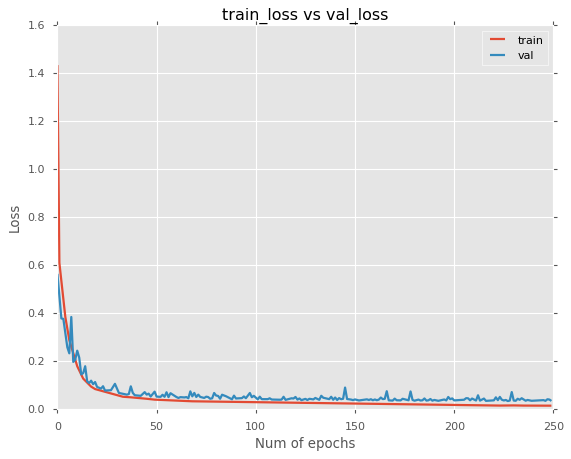